In [1]:
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import torchvision, cv2
from utils.visualizations import plot_samples
from utils.transforms import *
import utils.dataset as ds


In [2]:
import utils.dataset as ds
import torchvision, cv2
import importlib

importlib.reload(ds)

physionet = ds.PhysionetDataset(train=True)
slp = ds.SLPDataset()
cifar = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)


Files already downloaded and verified


## Zero Component Analysis


In [3]:
from utils.transforms import *
import utils.transforms as tf
import importlib

importlib.reload(tf)

physionet_zca = deepcopy(physionet)
slp_zca = deepcopy(slp)
cifar_zca = deepcopy(cifar)
physionet_zca.x = zca(physionet_zca.x, epsilon=0.1)
slp_zca.x = np.load("./data/SLP/data_zca.npy")
cifar_zca.data = zca(cifar_zca.data, epsilon=0.1)


(1000, 64, 32)
(1000, 2048)
(1000, 32, 32, 3)
(1000, 3072)


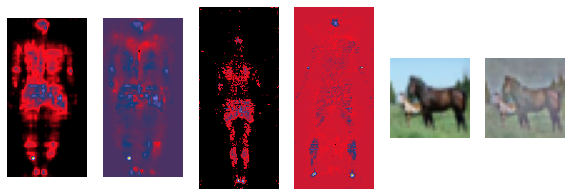

In [22]:
from utils.visualizations import *
import utils.visualizations as vi
import importlib

importlib.reload(vi)

image_row(
    physionet[0][0],
    physionet_zca[0][0],
    slp[0][0],
    slp_zca[0][0],
    cifar.data[12],
    cifar_zca.data[12],
)


In [38]:
indices_per_class = {}
for i, label in enumerate(ds.PostureClass):
    indices_per_class[i] = np.where(physionet.y == i)[0]
# print(indices_per_class)
samples = [
    sample
    for sample in map(
        lambda c: physionet[random.choice(c)] if len(c) > 0 else None,
        list(indices_per_class.values()) * 10,
    )
    if sample is not None
]


In [51]:
basic_transform = [
    Normalize(),
    EqualizeHist(),
    Blur((3, 3)),
    Threshold(lambda img: np.median(img[img > 0.0])),
]


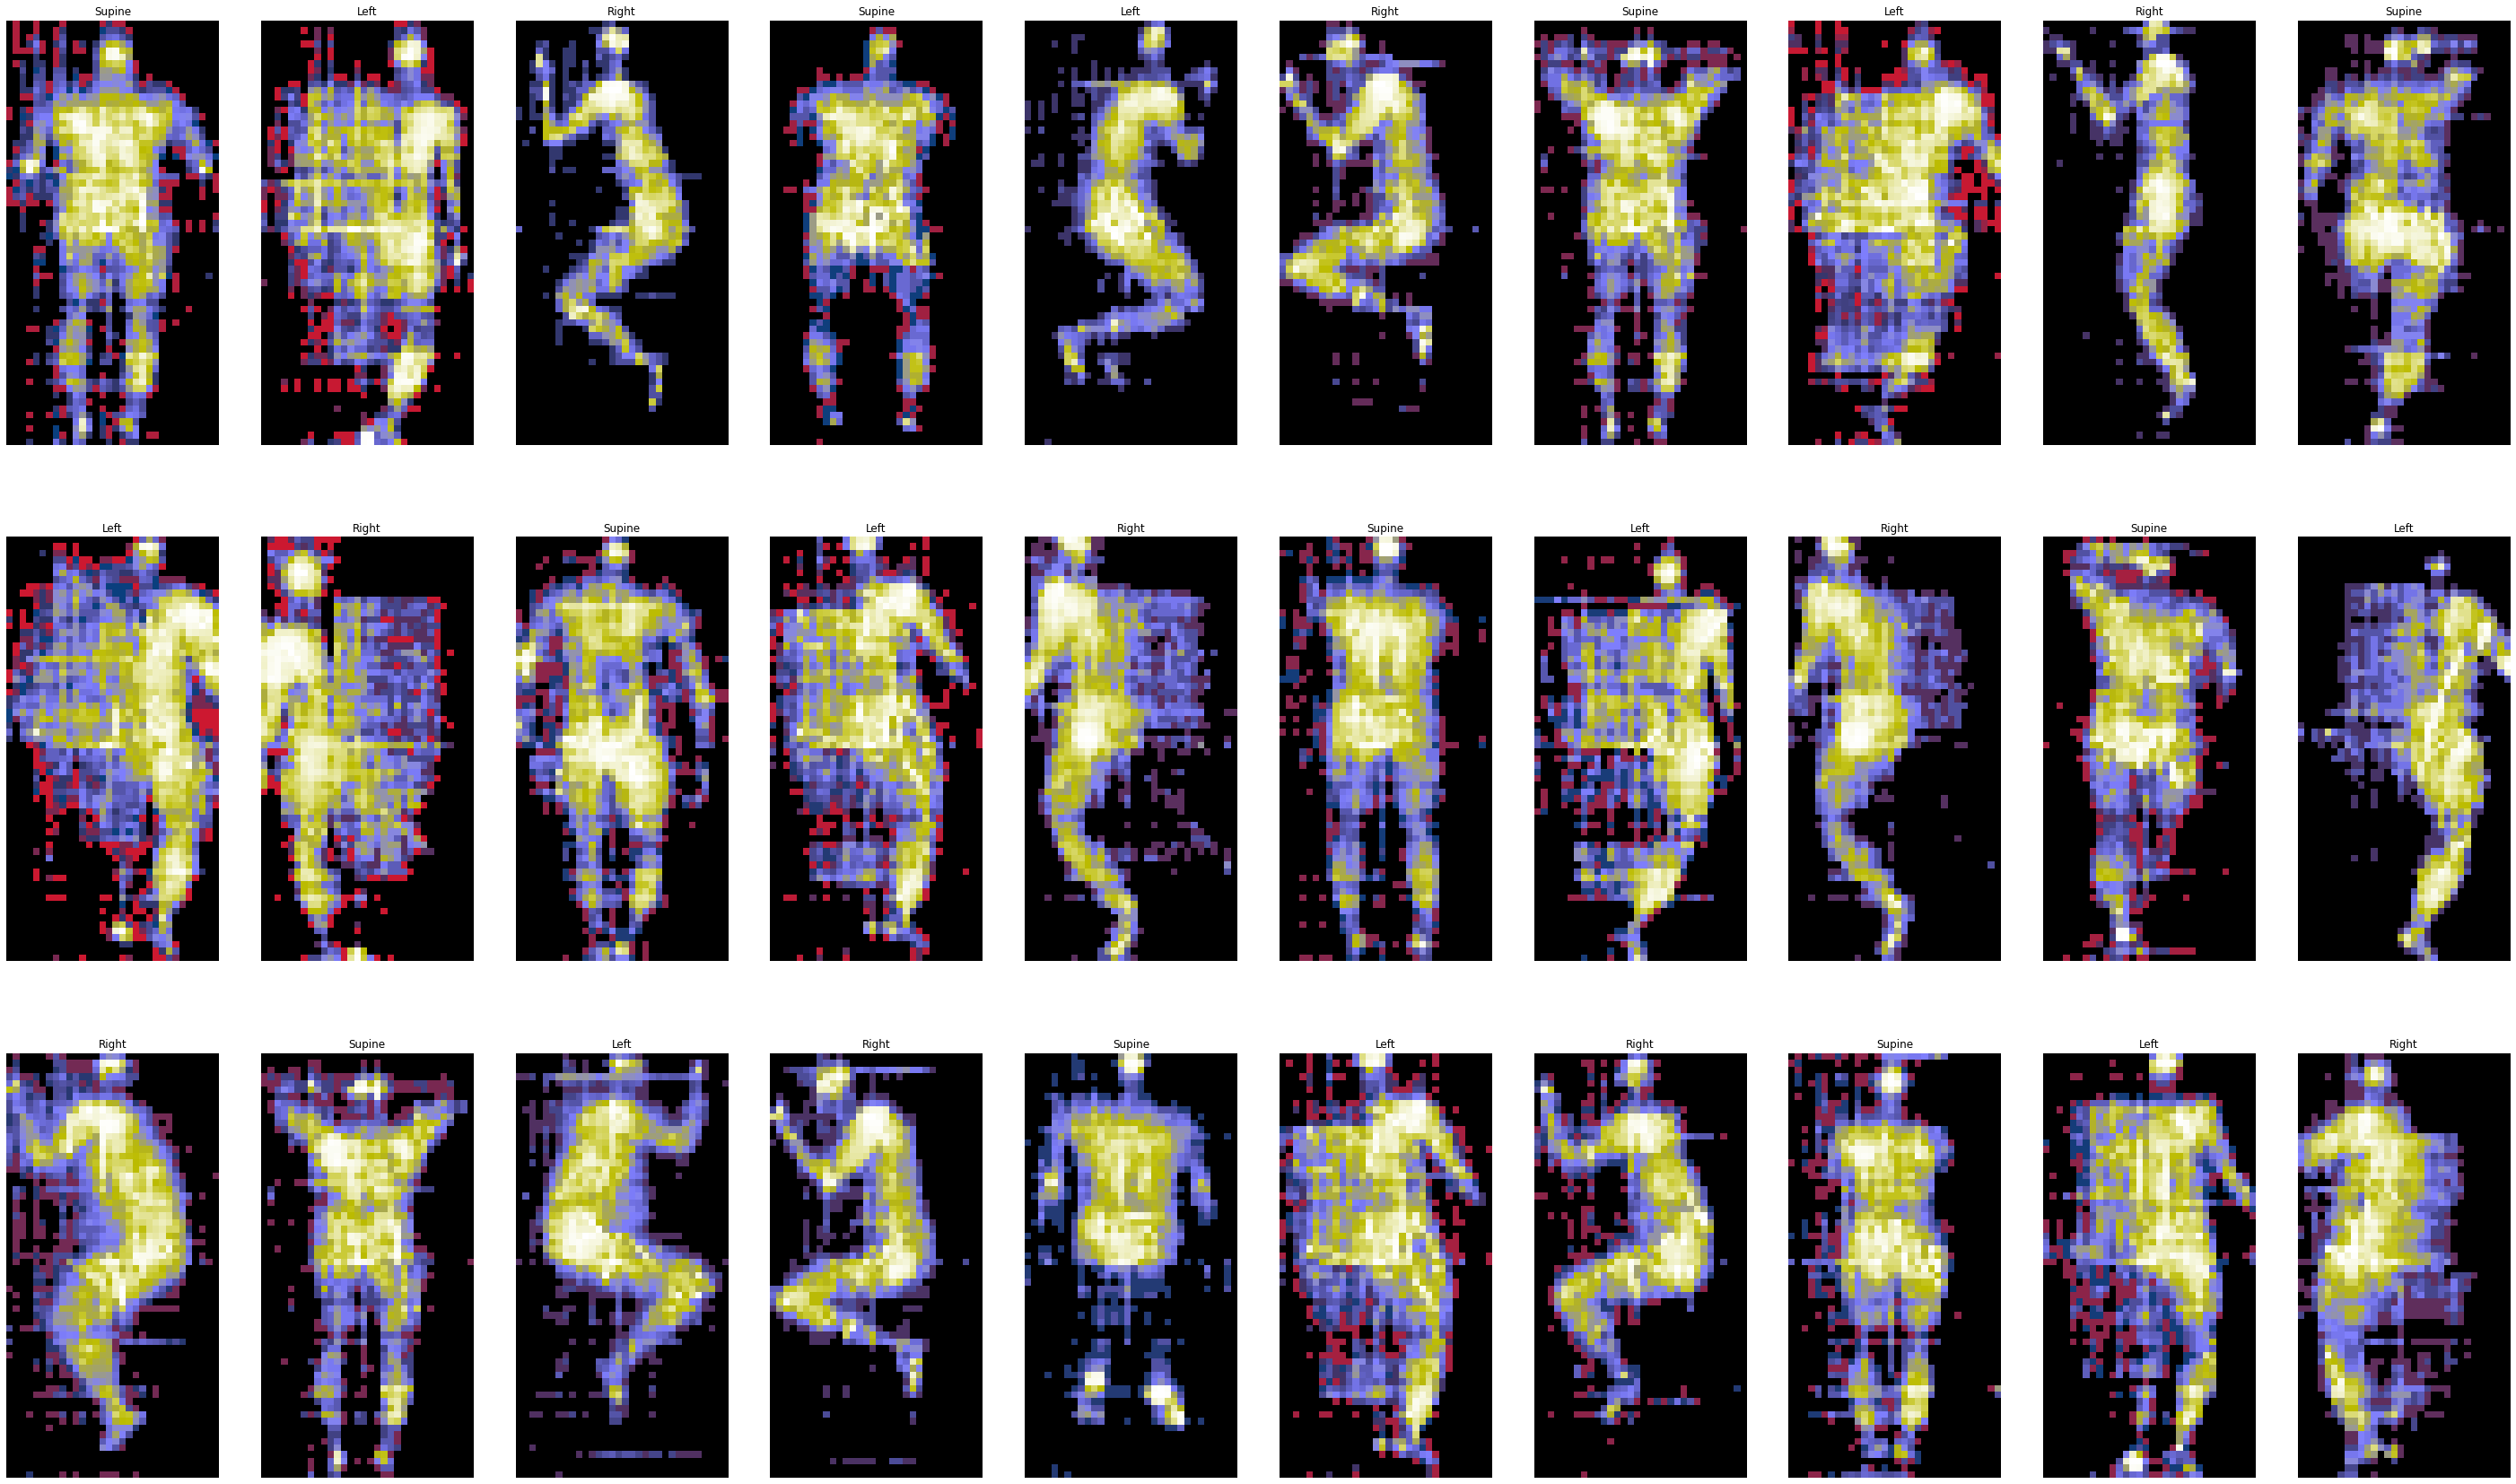

In [46]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib

importlib.reload(tf)
importlib.reload(vi)

plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            Normalize(),
            EqualizeHist(),
        ]
    ),
)


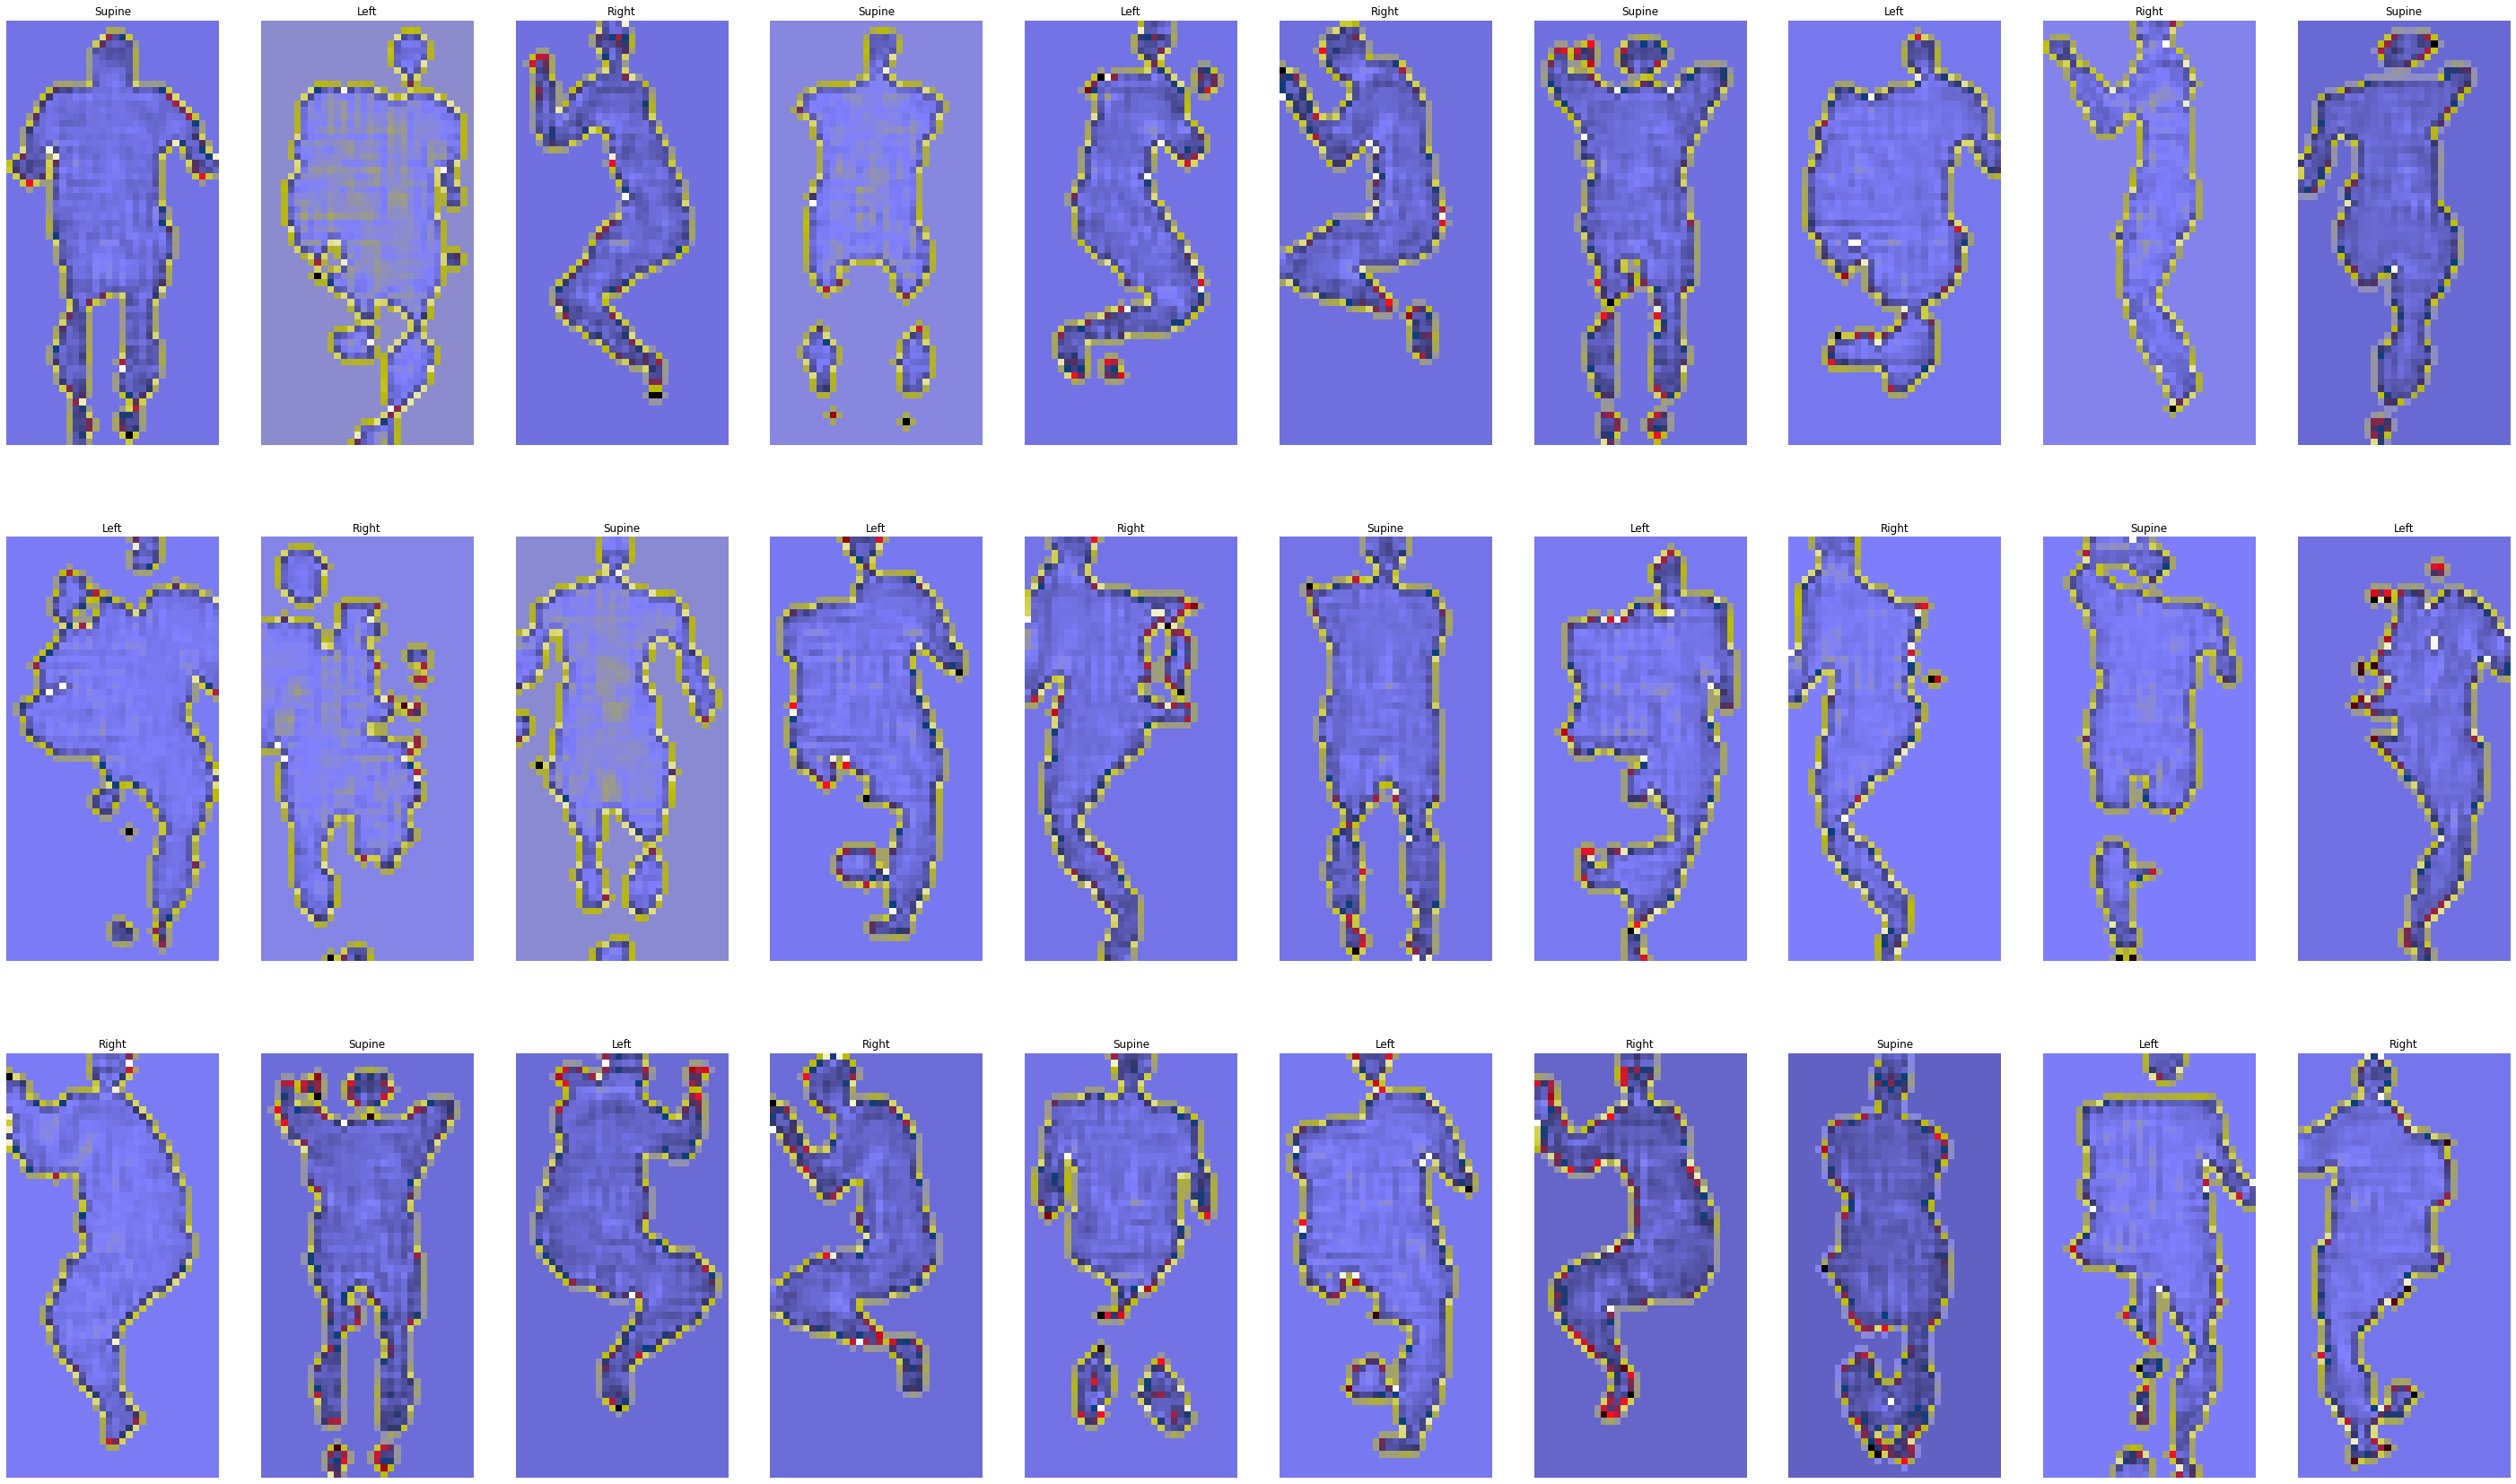

In [48]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib

importlib.reload(tf)
importlib.reload(vi)

plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            *basic_transform,
            Laplace(),
        ]
    ),
)


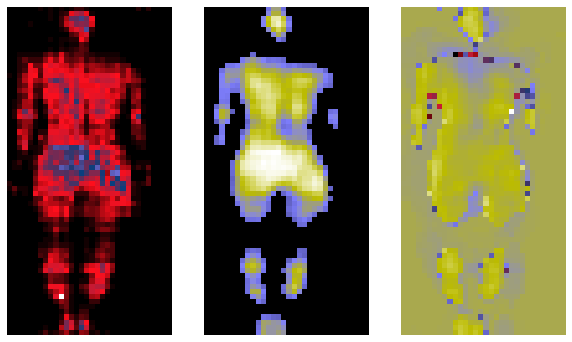

In [49]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib

importlib.reload(tf)
importlib.reload(vi)

transforms = torchvision.transforms.Compose(
    basic_transform
)

physionet_transformed = np.array(
    list(map(lambda i: i[0], [transforms(sample) for sample in physionet]))
)
zca_transformed_physionet = zca(physionet_transformed, epsilon=0.1)

image_row(physionet[0][0], physionet_transformed[0], zca_transformed_physionet[0])


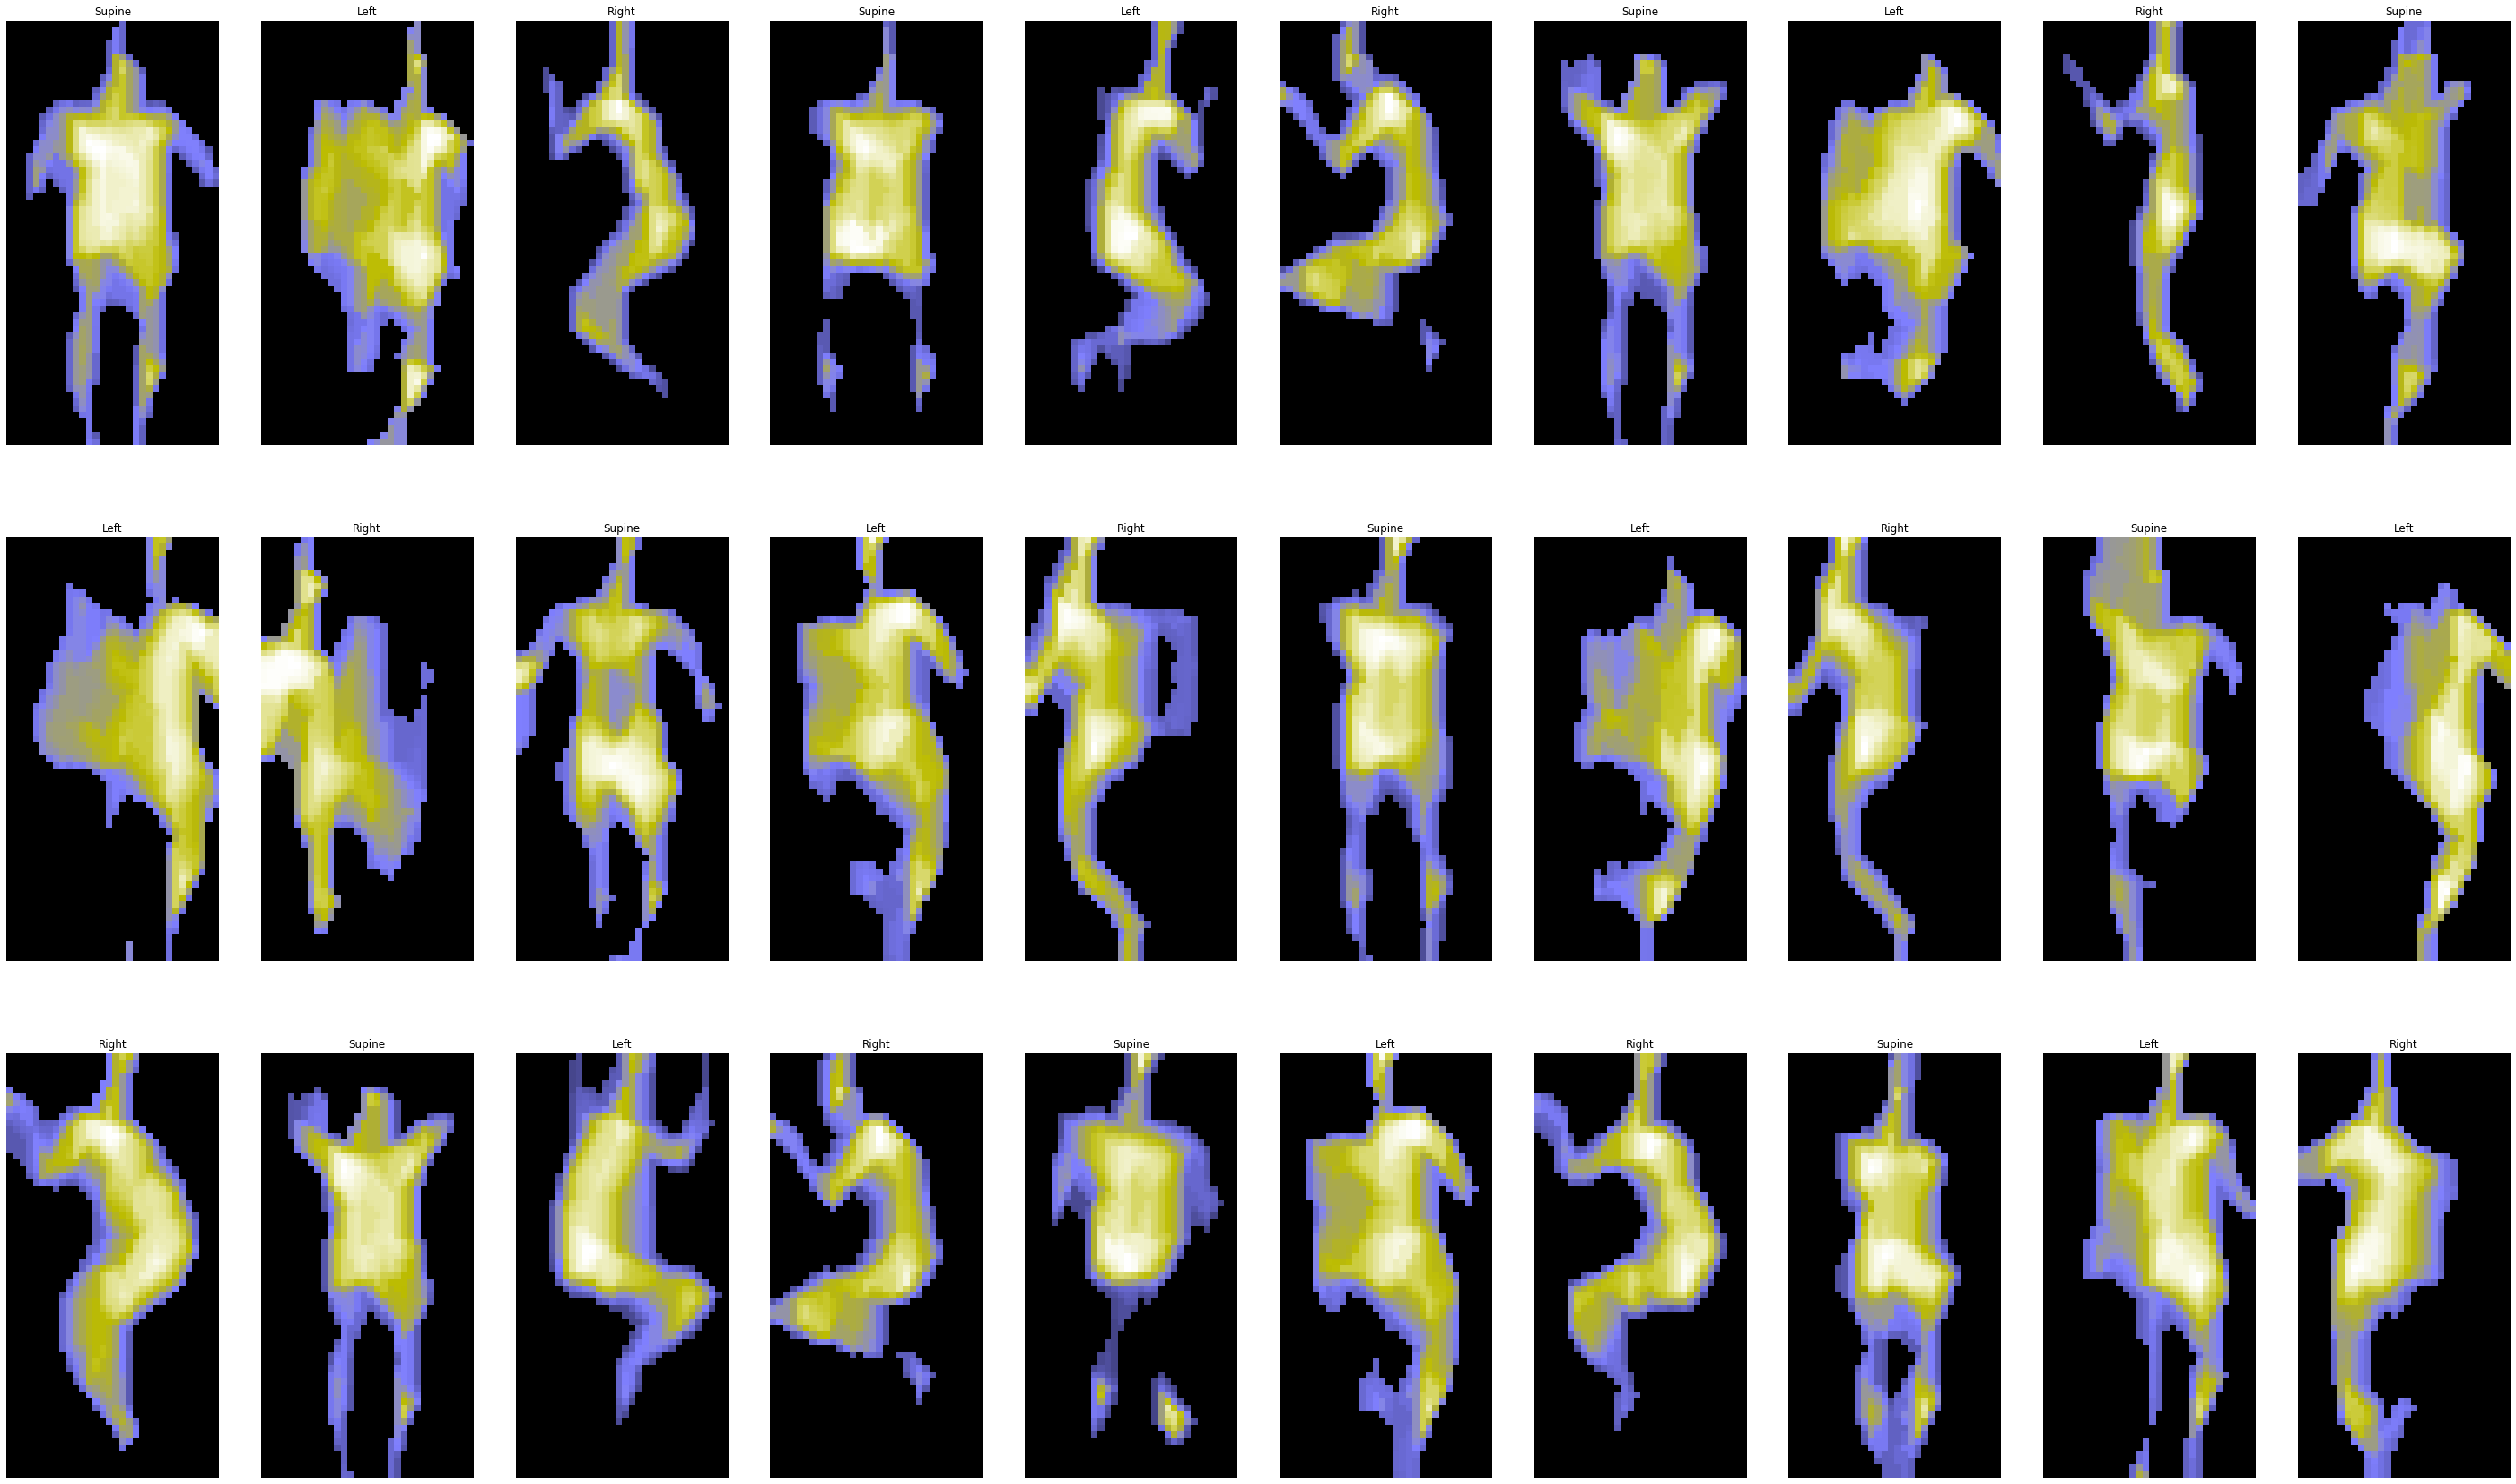

In [52]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            *basic_transform,
            Close((2, 4), ktype=cv2.MORPH_CROSS, iterations=2),
            # Erode((2,2), ktype=cv2.MORPH_CROSS, iterations=2),
            # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=2),
        ]
    ),
)


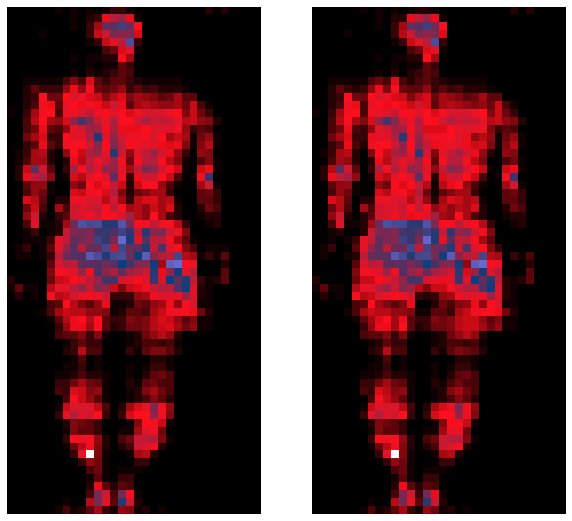

In [58]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib

importlib.reload(tf)
importlib.reload(vi)

transforms = torchvision.transforms.Compose(
    [
        Normalize(),
        RollingBall(radius=75),
    ]
)

sample = physionet[0]
image = sample[0]

vi.image_row(image, transforms(sample)[0])


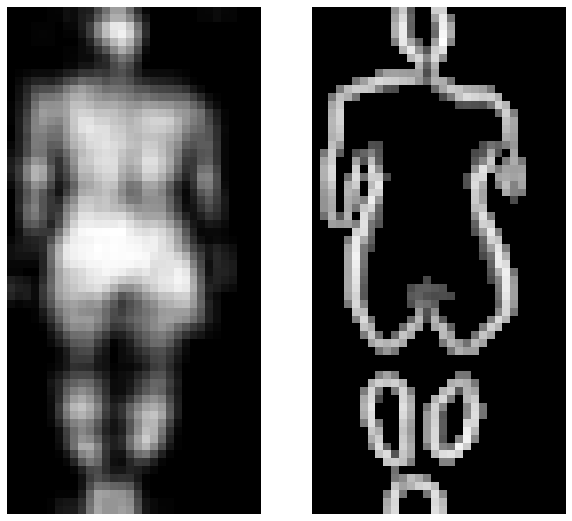

In [62]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib

importlib.reload(tf)
importlib.reload(vi)

transforms_base = [
    *basic_transform,
    Sobel(),
    # Blur((3, 3)),
    Threshold(lambda img: np.median(img[img > 0.0])),
]

base_transform = torchvision.transforms.Compose(transforms_base[:3])
sobel_transform = torchvision.transforms.Compose(transforms_base)

sample = base_transform(physionet[0])
sobel = sobel_transform(sample)

image_row(sample[0], sobel[0], cmap="gray")


C:\Users\Jannis\AppData\Local\Temp\ipykernel_15068\1735997314.py:23: RuntimeWarning: divide by zero encountered in log
  manip_magnitude_spectrum = np.log(np.abs(fshift))


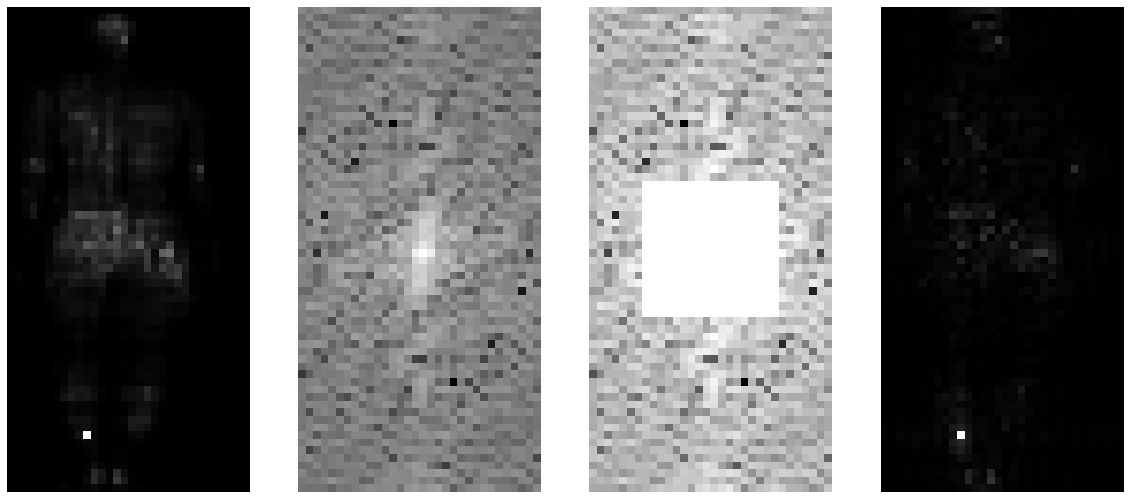

In [109]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib

importlib.reload(tf)
importlib.reload(vi)
from skimage import data, filters

image = physionet[0][0]  # data.coins()
image = np.reshape(image, image.shape[1:])
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift))

rows, cols = image.shape
crow, ccol = int(rows / 2), int(cols / 2)
rect_rad = 9
keep = 100
# fshift[keep:rows-keep] = 0
# fshift[:, keep:cols-keep] = 0
fshift[crow - rect_rad : crow + rect_rad, ccol - rect_rad : ccol + rect_rad] = 0
manip_magnitude_spectrum = np.log(np.abs(fshift))
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

image_row(
    image,
    magnitude_spectrum,
    manip_magnitude_spectrum,
    img_back,
    cmap="gray",
    figsize=(20, 20),
)
